# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [143]:
# create all possible n-mers for 6 and 8
seqs6 = [''.join(x) for x in product(['A','C','G','T'], repeat=6)]
print('Total 6mers:',len(seqs6))

seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 6mers: 4096
Total 8mers: 65536


In [3]:
# if you want to down select
seqs6_200 = u.downselect_list(seqs6,200)
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer6 = score_seqs(seqs6)
mer6.head()

,seq,score
0,AAAAAA,20.0
1,AAAAAC,19.5
2,AAAAAG,19.0
3,AAAAAT,18.5
4,AAAACA,19.5


In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [7]:
mer6_motif = score_seqs_motif(seqs6)
mer8_motif = score_seqs_motif(seqs8)


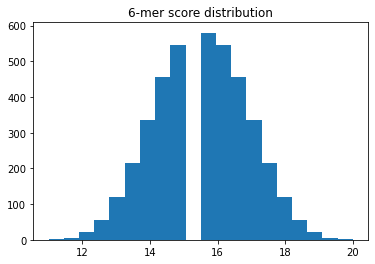

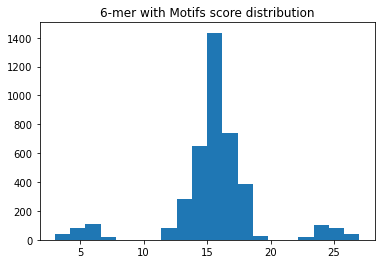

In [8]:
plt.hist(mer6['score'].values,bins=20)
plt.title("6-mer score distribution")
plt.show()

plt.hist(mer6_motif['score'].values,bins=20)
plt.title("6-mer with Motifs score distribution")
plt.show()

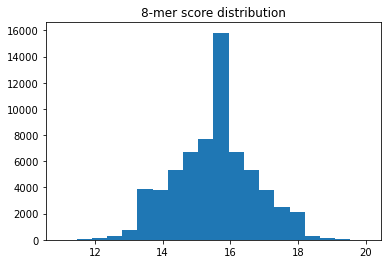

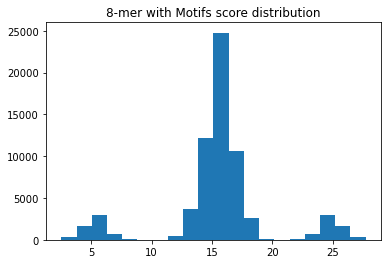

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.show()

### Define some basic model archs for Linear and CNN

In [10]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        xb = self.conv_net(xb)
        return xb

# Single Task, Simple Sequence Regression
#### Linear Regression

In [11]:
mer6_train_dl, mer6_test_dl, mer6_train_df, mer6_test_df = u.build_dataloaders_single(mer6)

In [12]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

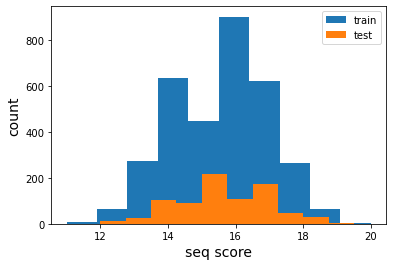

In [13]:
plot_train_test_hist(mer6_train_df, mer6_test_df)

#### Run linear model

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 0.002089641997363509
1 0.0015069687966166472
2 0.0014857372269034385
3 0.0013464352002412808
4 0.001388465532487849
5 0.0013639272792582832
6 0.0011832292532412017
7 0.0011906587427890883
8 0.0011142054686277378
9 0.0010704771615564824
10 0.0010234009122430552
11 0.0010720265381855935
12 0.0009485931487799418
13 0.0009252331713668821
14 0.0008801898243269179
15 0.001111065566244467
16 0.0008220456154426424
17 0.0008019222344112832
18 0.0007783361835541522
19 0.000823725284667822


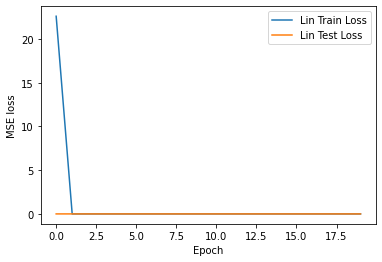

In [14]:
seq_len = len(mer6_train_df['seq'].values[0])
hidden_layer_size = 24

mer6_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6_train_losses, mer6_test_losses = u.run_model(mer6_train_dl, mer6_test_dl, mer6_model_lin)

# to plot loss
mer6_lin_data_label = list(zip([mer6_train_losses,mer6_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6_lin_data_label)

In [15]:
def quick_test(model):
    '''Spot check predictions for a few sequences '''
    seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT']
    seqs2 = ['AACCAA','CCGGGG','GGGTAA', 'TTTCGT','TGTAAT']
    seqsTAT = ['TATAAA','CCTATC','GTATGG','TTTATT']
    seqsGCG = ['AAGCGA','CGCGCC','GGGCGG','TTGCGT']
    TATGCG =  ['TATGCG','GCGTAT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs)
        print()

In [16]:
quick_test(mer6_model_lin)

AAAAAA 20.001205444335938
CCCCCC 16.997020721435547
GGGGGG 13.983773231506348
TTTTTT 11.035481452941895

AACCAA 19.040258407592773
CCGGGG 15.016060829162598
GGGTAA 15.46951961517334
TTTCGT 12.57240104675293
TGTAAT 14.54238510131836

TATAAA 17.019004821777344
CCTATC 15.534765243530273
GTATGG 13.983901023864746
TTTATT 12.50563907623291

AAGCGA 17.548002243041992
CGCGCC 16.00901222229004
GGGCGG 14.471680641174316
TTGCGT 13.008796691894531

TATGCG 14.505456924438477
GCGTAT 14.496964454650879



# Single task Regression with Motifs
### Linear Model

In [17]:
mer6motif_train_dl, mer6motif_test_dl, mer6motif_train_df, mer6motif_test_df = u.build_dataloaders_single(mer6_motif)

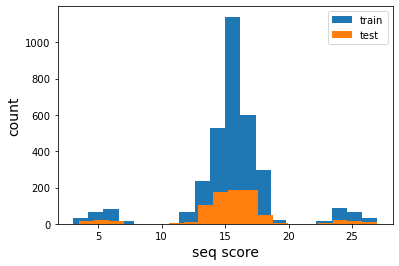

In [18]:
plot_train_test_hist(mer6motif_train_df, mer6motif_test_df,bins=20)

0 9.494579073277915
1 9.429597198672411
2 10.08030355500012
3 9.45544630841511
4 9.435254664537384
5 9.50504378807254
6 8.980757499322658
7 9.0620136772714
8 8.487795080789706
9 11.57083034050174
10 7.671247770728135
11 8.44103092565769
12 7.169032334118355
13 6.943637164046125
14 7.386213614300984
15 6.4420752222945055
16 7.305174776402915
17 6.661915816330328
18 5.992470713359554
19 5.9304497509467895


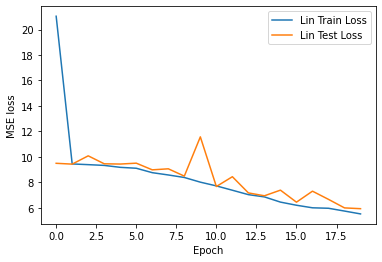

In [19]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6motif_train_losses_lin, mer6motif_test_losses_lin = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_lin,lr=0.01)

# to plot loss
mer6motif_lin_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6motif_lin_data_label)

In [20]:
quick_test(mer6motif_model_lin)

AAAAAA 19.95594024658203
CCCCCC 17.7038516998291
GGGGGG 10.164972305297852
TTTTTT 12.834358215332031

AACCAA 19.97047233581543
CCGGGG 11.972475051879883
GGGTAA 17.62311363220215
TTTCGT 12.966973304748535
TGTAAT 17.072036743164062

TATAAA 22.837799072265625
CCTATC 21.19529914855957
GTATGG 18.259822845458984
TTTATT 18.146940231323242

AAGCGA 12.430500030517578
CGCGCC 8.778480529785156
GGGCGG 9.850539207458496
TTGCGT 9.05581283569336

TATGCG 15.639512062072754
GCGTAT 14.587215423583984



### CNN Model

0 16.75896991636695
1 7.504822544935273
2 14.020912449534347
3 4.982197602202253
4 2.511407478844247
5 1.7925761641525642
6 0.7965310518334552
7 0.5783041561522135
8 0.3161594347255986
9 0.31794226787439206
10 0.1940258750464858
11 0.17616610258090787
12 0.18649179742830554
13 0.19254515759828614
14 0.3145875237336973
15 0.1747069833482184
16 0.16182455202428306
17 0.16060588290778602
18 0.2827295344050338
19 0.218656536573317


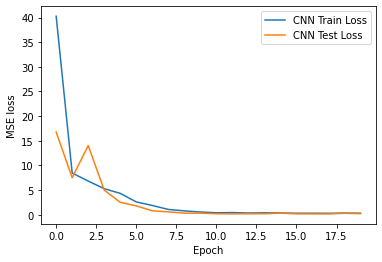

In [21]:
seq_len = len(mer6motif_train_df['seq'].values[0])

mer6motif_model_cnn = DNA_CNN(seq_len, num_filters=32,kernel_size=3)

mer6motif_train_losses_cnn, mer6motif_test_losses_cnn = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_cnn, lr=0.01)

# to plot loss
mer6motif_cnn_data_label = list(zip([mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer6motif_cnn_data_label)

In [22]:
quick_test(mer6motif_model_cnn)

AAAAAA 19.560033798217773
CCCCCC 16.634244918823242
GGGGGG 13.729256629943848
TTTTTT 11.031063079833984

AACCAA 18.613235473632812
CCGGGG 14.794262886047363
GGGTAA 15.481064796447754
TTTCGT 12.490550994873047
TGTAAT 14.468320846557617

TATAAA 25.437997817993164
CCTATC 24.5909423828125
GTATGG 23.29978370666504
TTTATT 21.705768585205078

AAGCGA 7.099041938781738
CGCGCC 6.007163047790527
GGGCGG 4.455760955810547
TTGCGT 4.154135227203369

TATGCG 13.341438293457031
GCGTAT 13.606273651123047



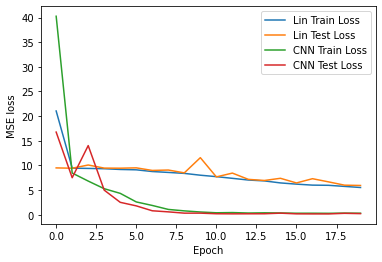

In [23]:
comb_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin,mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

u.quick_loss_plot(comb_data_label)

# Try with 8 mers

### Single Task Regression


In [24]:
mer8_train_dl, mer8_test_dl, mer8_train_df, mer8_test_df = u.build_dataloaders_single(mer8)

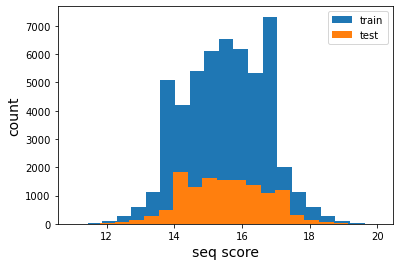

In [25]:
plot_train_test_hist(mer8_train_df, mer8_test_df,bins=20)

0 0.0004305010731289374
1 0.0002989128597394322
2 0.0002141434988985307
3 0.000160148810333153
4 0.00013877891276890657
5 0.00010409812927749838
6 0.0001290847509313954
7 6.609517607477444e-05
8 5.535925448252274e-05
9 5.26085796345705e-05
10 4.112532298812135e-05
11 8.13817004027339e-05
12 3.20881768315606e-05
13 2.815772438239549e-05
14 2.6075404070959042e-05
15 2.469210668635169e-05
16 2.0736407467740243e-05
17 1.897317246889211e-05
18 1.794843973289624e-05
19 2.077735407988139e-05


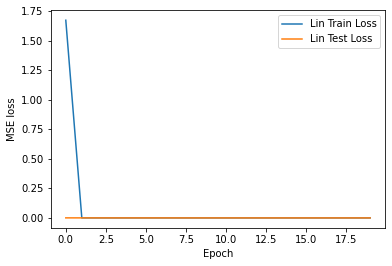

In [26]:
seq_len = len(mer8_train_df['seq'].values[0])
hidden_layer_size = 24

mer8_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8_train_losses, mer8_test_losses = u.run_model(mer8_train_dl, mer8_test_dl, mer8_model_lin)

# to plot loss
mer8_lin_data_label = list(zip([mer8_train_losses,mer8_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer8_lin_data_label)

In [27]:
def quick_test8(model):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs)
        print()

In [28]:
quick_test8(mer8_model_lin)

AAAAAAAA 19.994918823242188
CCCCCCCC 17.008167266845703
GGGGGGGG 14.000774383544922
TTTTTTTT 10.99640941619873

AACCAACA 18.869991302490234
CCGGCGCG 15.50191593170166
GGGTAAGG 15.124022483825684
TTTCGTTT 12.12144947052002
TGTAATAC 15.494786262512207

TATAAAAA 17.75299644470215
CCTATCCC 15.871280670166016
GTATGGGG 13.997013092041016
TTTATTTT 12.120579719543457

AAGCGAAA 18.12128257751465
CGCGCCCC 16.264394760131836
GGGCGGGG 14.373993873596191
TTGCGTTT 12.496553421020508

ATATGCGA 15.871503829956055
TGCGTATT 13.616806983947754



# Single task Regression with Motifs
### Linear Model

In [29]:
mer8motif_train_dl, mer8motif_test_dl, mer8motif_train_df, mer8motif_test_df = u.build_dataloaders_single(mer8_motif)

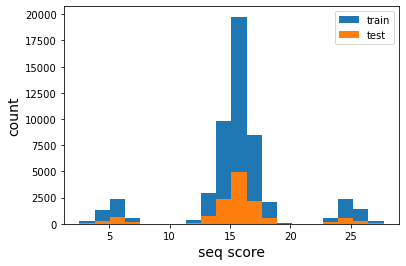

In [30]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

0 13.593815547720775
1 6.9220453357783835
2 6.14844478497172
3 4.536143054676958
4 3.8755659904282087
5 2.4515045955117825
6 4.3172477244021215
7 1.9534441660117696
8 1.8919153458322007
9 2.131486423866102
10 1.6789637406424556
11 4.140558337670548
12 1.3969097133813415
13 1.2940983062915261
14 1.2074475649620362
15 1.7873446109056983
16 4.121743241788266
17 1.1300441605909444
18 2.660691524956115
19 1.2152478263114042


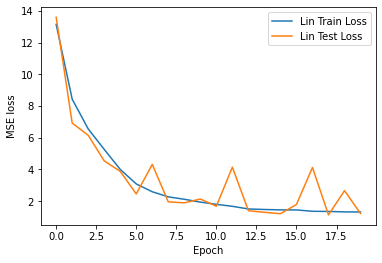

In [31]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8motif_train_losses_lin, mer8motif_test_losses_lin = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_lin,lr=0.01)

# to plot loss
mer8motif_lin_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer8motif_lin_data_label)

In [32]:
quick_test8(mer8motif_model_lin)

AAAAAAAA 19.652433395385742
CCCCCCCC 18.1004581451416
GGGGGGGG 13.832253456115723
TTTTTTTT 11.786829948425293

AACCAACA 18.682769775390625
CCGGCGCG 0.0
GGGTAAGG 15.705945014953613
TTTCGTTT 11.723905563354492
TGTAATAC 16.00788688659668

TATAAAAA 25.367965698242188
CCTATCCC 24.66497802734375
GTATGGGG 23.55857276916504
TTTATTTT 20.120534896850586

AAGCGAAA 9.48476505279541
CGCGCCCC 7.2282185554504395
GGGCGGGG 6.47160005569458
TTGCGTTT 3.408381938934326

ATATGCGA 15.754199028015137
TGCGTATT 12.780299186706543



### CNN Model

0 0.778225345949156
1 0.5647542977936937
2 0.535196858210683
3 0.3764863959469554
4 0.35568698719121133
5 0.1833156477438265
6 1.1657714641308836
7 0.6806710773500902
8 0.09084979595254389
9 0.19110045893766328
10 0.05836536211288754
11 0.2641807137728465
12 0.8284382608775726
13 0.09099469609901896
14 0.06273454937232424
15 0.026282472079827233
16 0.02989708112770459
17 0.013130829111651055
18 0.013623048903362023
19 0.008811002106470876


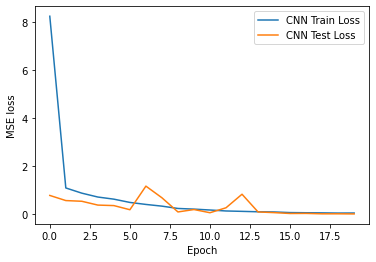

In [33]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len, num_filters=32,kernel_size=3)

mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn, lr=0.01)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [34]:
quick_test8(mer8motif_model_cnn)

AAAAAAAA 19.973522186279297
CCCCCCCC 17.082937240600586
GGGGGGGG 14.002760887145996
TTTTTTTT 10.9757719039917

AACCAACA 18.882137298583984
CCGGCGCG 4.794817924499512
GGGTAAGG 15.06721305847168
TTTCGTTT 12.231487274169922
TGTAATAC 15.528227806091309

TATAAAAA 27.74114990234375
CCTATCCC 25.86743927001953
GTATGGGG 23.97576904296875
TTTATTTT 22.152854919433594

AAGCGAAA 8.155653953552246
CGCGCCCC 6.271352767944336
GGGCGGGG 4.499585151672363
TTGCGTTT 2.5429515838623047

ATATGCGA 15.959564208984375
TGCGTATT 13.423133850097656



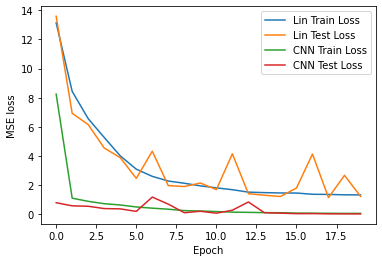

In [35]:
comb_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin,mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

u.quick_loss_plot(comb_data_label)

# inspect

### 6mer model

In [36]:
mer6motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [37]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer6motif_model_cnn)

Total convolutional layers: 1


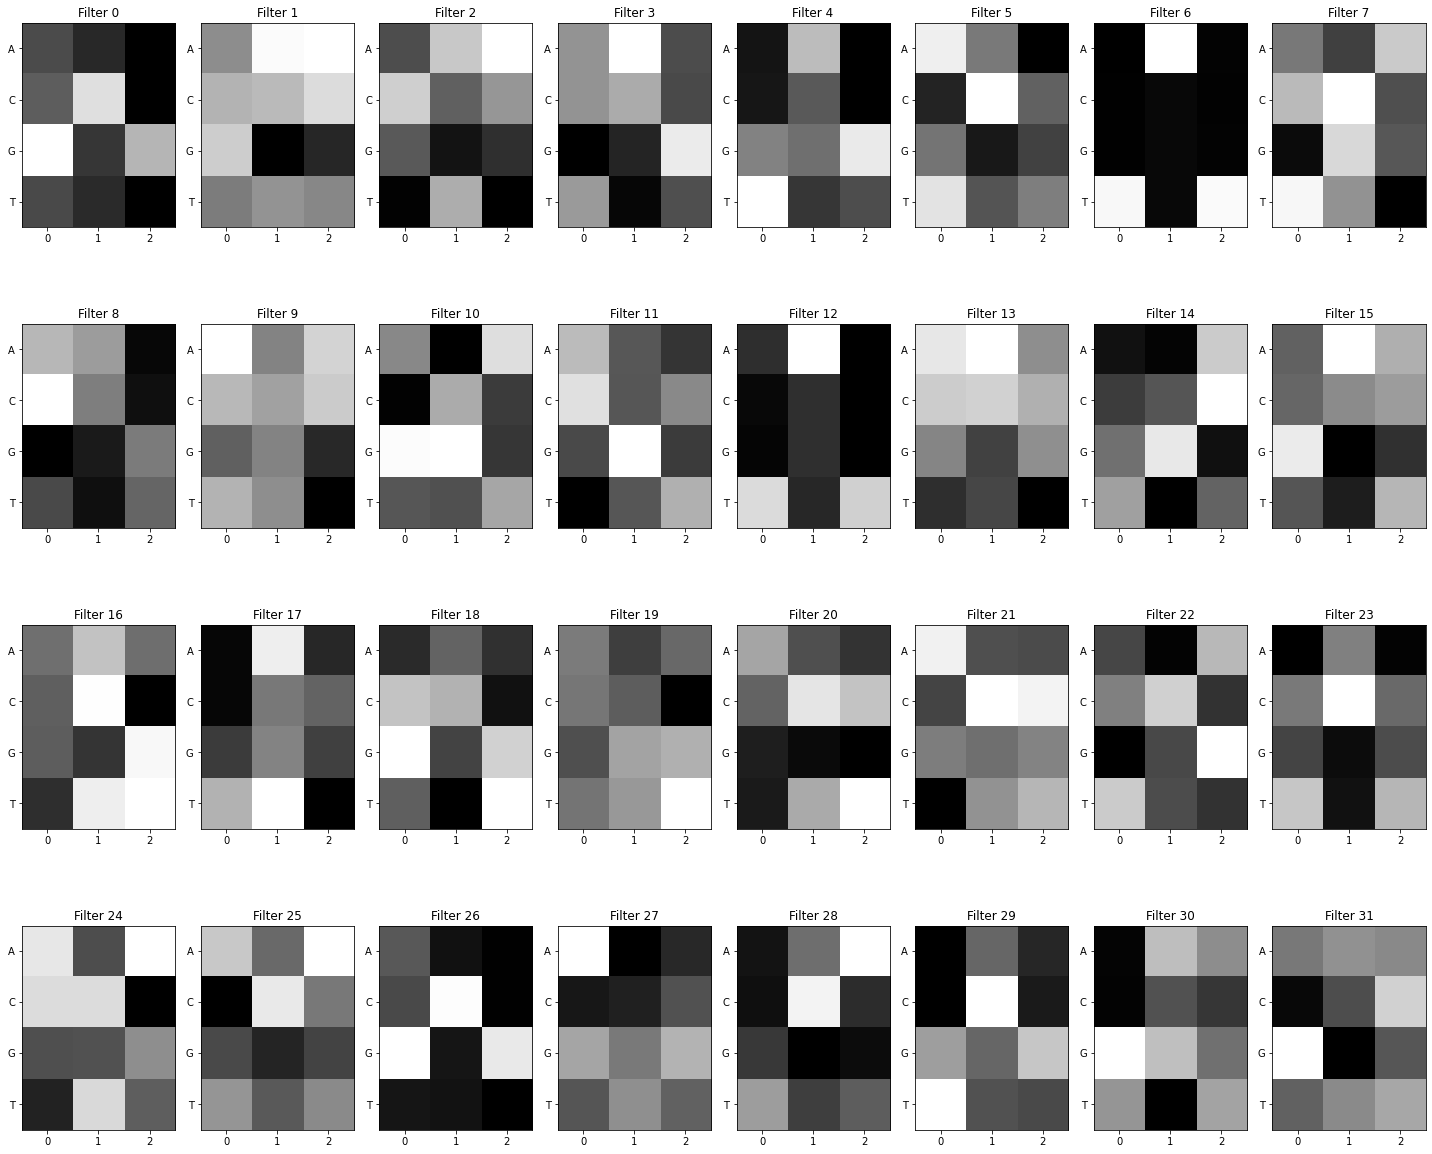

In [38]:
u.view_filters(model_weights)

In [39]:
train_seqs = list(mer6motif_train_df['seq'])
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGCACC
Running seq AGCACG
Running seq AGCACT
Running seq AGCAGA
Running seq AGCAGC
Running seq AGCAGG
Running seq AGCAGT
Running seq AGCATC
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAG
Running seq AGCCAT
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTC
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAA
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq AGCTGT
Running seq AGCTTA
Running seq AGCTTC
Running seq AGCTTG
Running seq AGCTTT
Running seq AGGAAA
Running seq AGGAAC
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq 

Running seq CACTTT
Running seq CAGAAC
Running seq CAGAAT
Running seq CAGACA
Running seq CAGACC
Running seq CAGACG
Running seq CAGACT
Running seq CAGAGA
Running seq CAGAGC
Running seq CAGAGG
Running seq CAGAGT
Running seq CAGATA
Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAG
Running seq CAGCAT
Running seq CAGCCC
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGG
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGCTG
Running seq CAGCTT
Running seq CAGGAC
Running seq CAGGAG
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGC
Running seq CAGGGG
Running seq CAGGGT
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTT
Running seq CAGTAA
Running seq CAGTAC
Running seq CAGTAG
Running seq CAGTAT
Running seq CAGTCC
Running seq CAGTCG
Running seq CAGTCT
Running seq CAGTGC
Running seq CAGTGG
Running seq CAGTGT
Running seq CAGTTA
Running seq CAGTTC
Running seq CAGTTG
Running seq 

Running seq CGTAAC
Running seq CGTAAG
Running seq CGTACA
Running seq CGTACC
Running seq CGTACT
Running seq CGTAGA
Running seq CGTAGC
Running seq CGTAGG
Running seq CGTAGT
Running seq CGTATC
Running seq CGTATT
Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCCT
Running seq CGTCGA
Running seq CGTCGC
Running seq CGTCGG
Running seq CGTCGT
Running seq CGTCTA
Running seq CGTCTG
Running seq CGTGAA
Running seq CGTGAG
Running seq CGTGAT
Running seq CGTGCA
Running seq CGTGCC
Running seq CGTGCG
Running seq CGTGCT
Running seq CGTGGA
Running seq CGTGGC
Running seq CGTGGG
Running seq CGTGGT
Running seq CGTGTA
Running seq CGTGTC
Running seq CGTGTG
Running seq CGTGTT
Running seq CGTTAA
Running seq CGTTAC
Running seq CGTTAG
Running seq CGTTAT
Running seq CGTTCA
Running seq CGTTCC
Running seq CGTTCG
Running seq CGTTCT
Running seq CGTTGA
Running seq CGTTGC
Running seq CGTTGG
Running seq CGTTGT
Running seq 

Running seq GATGAG
Running seq GATGCA
Running seq GATGCC
Running seq GATGCG
Running seq GATGCT
Running seq GATGGC
Running seq GATGGG
Running seq GATGTA
Running seq GATGTC
Running seq GATGTG
Running seq GATGTT
Running seq GATTAA
Running seq GATTAC
Running seq GATTAT
Running seq GATTCA
Running seq GATTCC
Running seq GATTCG
Running seq GATTCT
Running seq GATTGA
Running seq GATTGC
Running seq GATTGT
Running seq GATTTA
Running seq GATTTC
Running seq GATTTG
Running seq GATTTT
Running seq GCAAAA
Running seq GCAAAC
Running seq GCAAAT
Running seq GCAACA
Running seq GCAACC
Running seq GCAACG
Running seq GCAACT
Running seq GCAAGA
Running seq GCAAGC
Running seq GCAAGG
Running seq GCAAGT
Running seq GCAATA
Running seq GCAATC
Running seq GCAATG
Running seq GCAATT
Running seq GCACAA
Running seq GCACAC
Running seq GCACCA
Running seq GCACCC
Running seq GCACCG
Running seq GCACCT
Running seq GCACGA
Running seq GCACGG
Running seq GCACGT
Running seq GCACTC
Running seq GCACTG
Running seq GCAGAA
Running seq 

Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCG
Running seq GTATCT
Running seq GTATGA
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAC
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCACG
Running seq GTCACT
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATA
Running seq GTCATC
Running seq GTCATG
Running seq GTCATT
Running seq GTCCAC
Running seq GTCCAG
Running seq GTCCAT
Running seq GTCCCA
Running seq GTCCCC
Running seq GTCCCG
Running seq GTCCCT
Running seq GTCCGA
Running seq GTCCGC
Running seq GTCCGG
Running seq GTCCGT
Running seq GTCCTA
Running seq GTCGAA
Running seq GTCGAC
Running seq GTCGAG
Running seq GTCGCA
Running seq GTCGCC
Running seq GTCGCG
Running seq GTCGCT
Running seq GTCGGA
Running seq GTCGGC
Running seq GTCGGG
Running seq GTCGGT
Running seq GTCGTA
Running seq 

Running seq TCCTAT
Running seq TCCTCA
Running seq TCCTCG
Running seq TCCTCT
Running seq TCCTGA
Running seq TCCTGC
Running seq TCCTGG
Running seq TCCTTA
Running seq TCCTTC
Running seq TCCTTG
Running seq TCCTTT
Running seq TCGAAA
Running seq TCGAAC
Running seq TCGAAG
Running seq TCGAAT
Running seq TCGACC
Running seq TCGACG
Running seq TCGAGC
Running seq TCGAGG
Running seq TCGAGT
Running seq TCGATA
Running seq TCGATC
Running seq TCGATG
Running seq TCGCAC
Running seq TCGCAT
Running seq TCGCCA
Running seq TCGCCC
Running seq TCGCCG
Running seq TCGCCT
Running seq TCGCGA
Running seq TCGCGC
Running seq TCGCGG
Running seq TCGCGT
Running seq TCGCTA
Running seq TCGCTC
Running seq TCGCTG
Running seq TCGCTT
Running seq TCGGAA
Running seq TCGGAC
Running seq TCGGAT
Running seq TCGGCA
Running seq TCGGCC
Running seq TCGGCT
Running seq TCGGGG
Running seq TCGGGT
Running seq TCGGTA
Running seq TCGGTC
Running seq TCGGTT
Running seq TCGTAA
Running seq TCGTAG
Running seq TCGTAT
Running seq TCGTCA
Running seq 

Running seq TTGAGA
Running seq TTGAGC
Running seq TTGAGG
Running seq TTGAGT
Running seq TTGATA
Running seq TTGATC
Running seq TTGATT
Running seq TTGCAA
Running seq TTGCAC
Running seq TTGCAG
Running seq TTGCAT
Running seq TTGCCA
Running seq TTGCCC
Running seq TTGCCT
Running seq TTGCGA
Running seq TTGCGT
Running seq TTGCTC
Running seq TTGCTG
Running seq TTGCTT
Running seq TTGGAC
Running seq TTGGAT
Running seq TTGGCA
Running seq TTGGCC
Running seq TTGGCT
Running seq TTGGGA
Running seq TTGGGC
Running seq TTGGGG
Running seq TTGGGT
Running seq TTGGTC
Running seq TTGGTT
Running seq TTGTAA
Running seq TTGTAC
Running seq TTGTAT
Running seq TTGTCA
Running seq TTGTCC
Running seq TTGTGA
Running seq TTGTGC
Running seq TTGTGG
Running seq TTGTGT
Running seq TTGTTA
Running seq TTGTTC
Running seq TTGTTG
Running seq TTTAAA
Running seq TTTAAC
Running seq TTTAAT
Running seq TTTACA
Running seq TTTACC
Running seq TTTACT
Running seq TTTAGG
Running seq TTTAGT
Running seq TTTATG
Running seq TTTATT
Running seq 

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


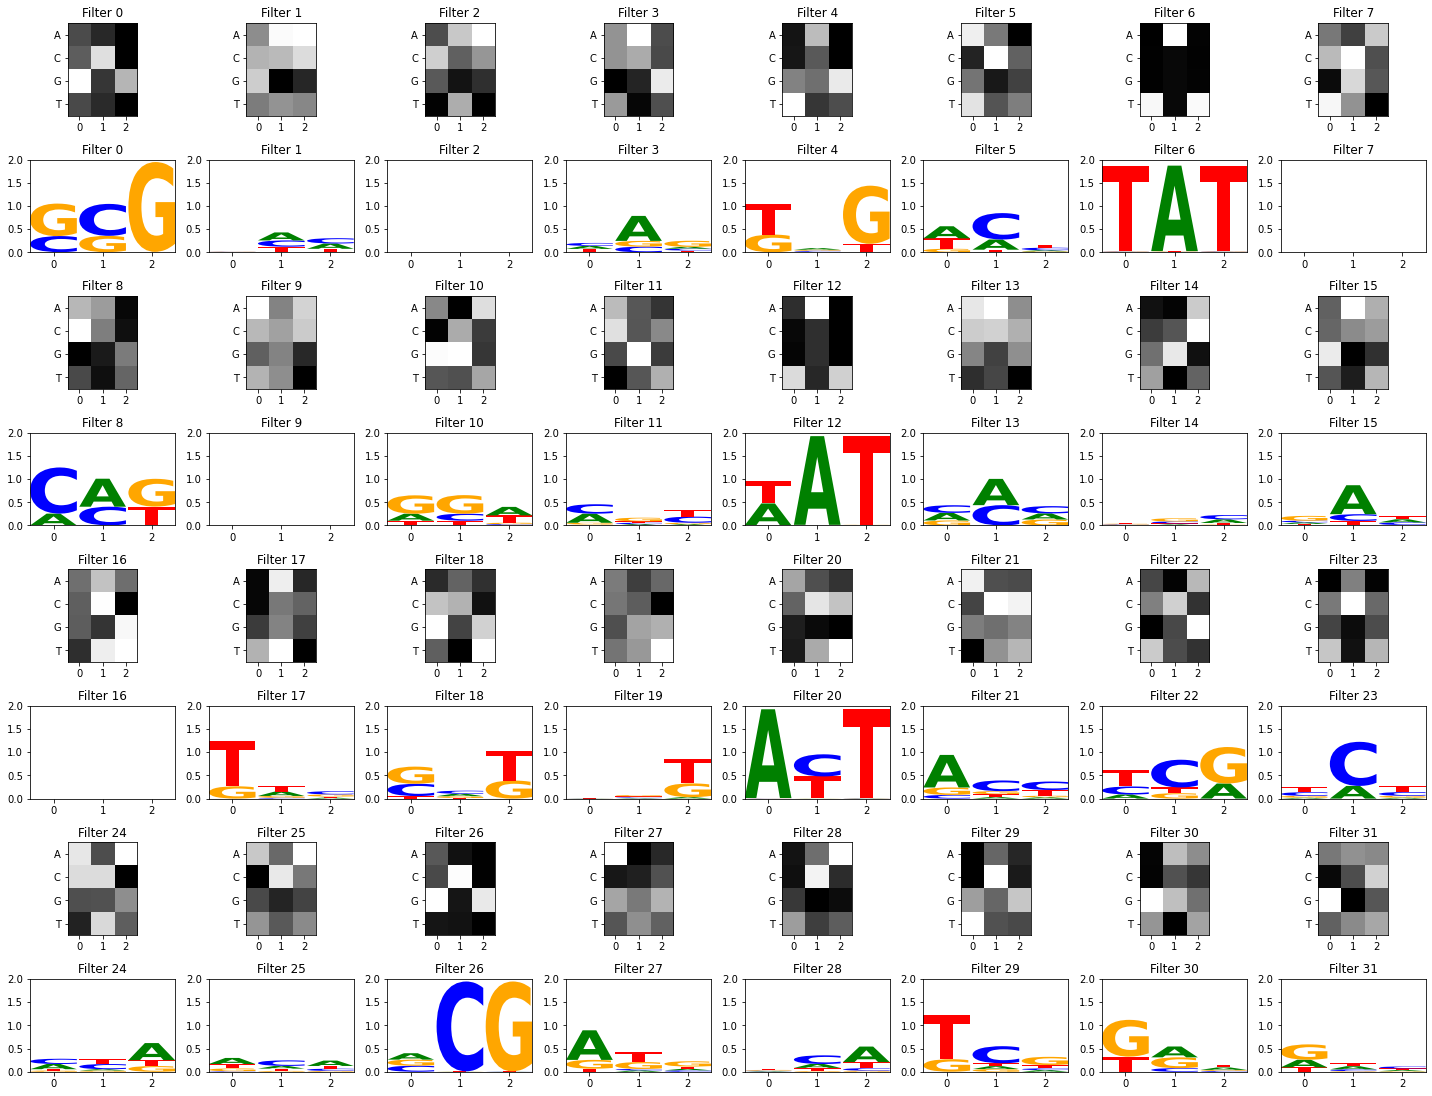

In [40]:
u.view_filters_and_logos(model_weights,filter_activations)

# 8mer model cnn

Total convolutional layers: 1


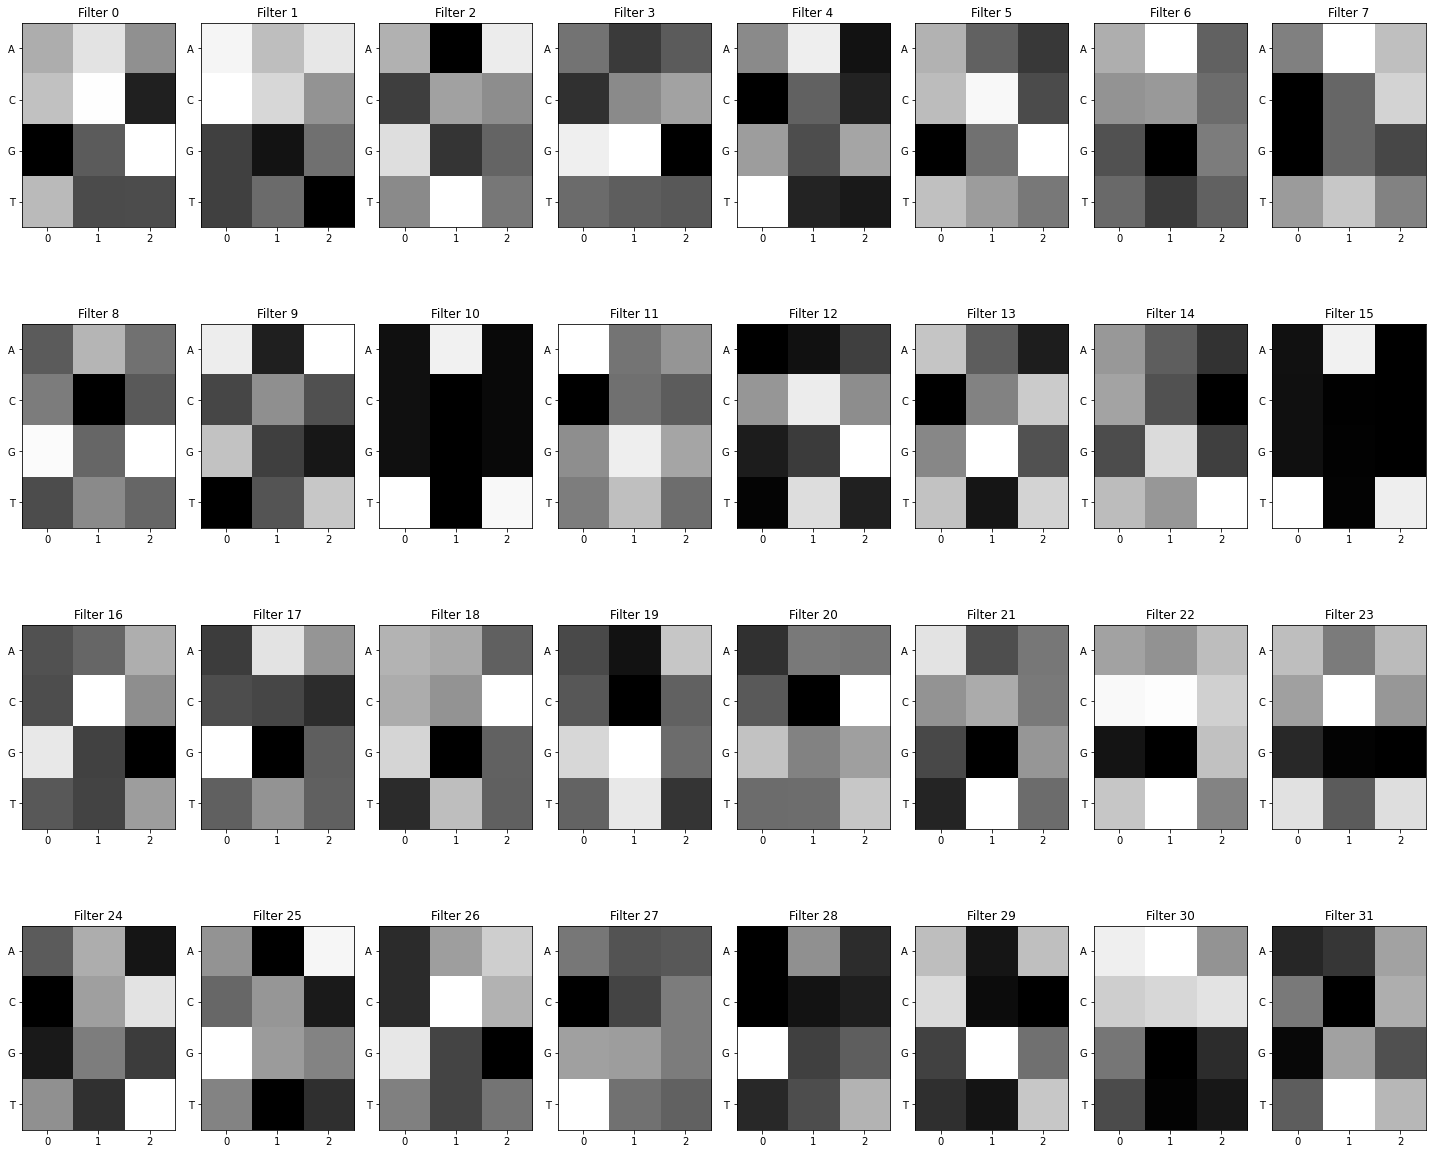

In [41]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer8motif_model_cnn)
u.view_filters(model_weights)

In [42]:
train_seqs = list(mer6motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGCATC
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAG
Running seq AGCCAT
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTC
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAA
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq AGCTGT
Running seq AGCTTA
Running seq AGCTTC
Running seq AGCTTG
Running seq AGCTTT
Running seq AGGAAA
Running seq AGGAAC
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq AGGACG
Running seq AGGACT
Running seq AGGAGA
Running seq AGGAGC
Running seq AGGAGG
Running seq AGGAGT
Running seq AGGATA
Running seq 

Running seq CAGCAA
Running seq CAGCAG
Running seq CAGCAT
Running seq CAGCCC
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGG
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGCTG
Running seq CAGCTT
Running seq CAGGAC
Running seq CAGGAG
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGC
Running seq CAGGGG
Running seq CAGGGT
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTT
Running seq CAGTAA
Running seq CAGTAC
Running seq CAGTAG
Running seq CAGTAT
Running seq CAGTCC
Running seq CAGTCG
Running seq CAGTCT
Running seq CAGTGC
Running seq CAGTGG
Running seq CAGTGT
Running seq CAGTTA
Running seq CAGTTC
Running seq CAGTTG
Running seq CAGTTT
Running seq CATAAA
Running seq CATAAG
Running seq CATAAT
Running seq CATACA
Running seq CATACC
Running seq CATACG
Running seq CATACT
Running seq CATAGA
Running seq CATAGC
Running seq CATAGG
Running seq CATAGT
Running seq CATATA
Running seq CATATC
Running seq 

Running seq CGGTAA
Running seq CGGTAC
Running seq CGGTAG
Running seq CGGTAT
Running seq CGGTCA
Running seq CGGTCC
Running seq CGGTCG
Running seq CGGTCT
Running seq CGGTGC
Running seq CGGTGG
Running seq CGGTGT
Running seq CGGTTC
Running seq CGTAAC
Running seq CGTAAG
Running seq CGTACA
Running seq CGTACC
Running seq CGTACT
Running seq CGTAGA
Running seq CGTAGC
Running seq CGTAGG
Running seq CGTAGT
Running seq CGTATC
Running seq CGTATT
Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCCT
Running seq CGTCGA
Running seq CGTCGC
Running seq CGTCGG
Running seq CGTCGT
Running seq CGTCTA
Running seq CGTCTG
Running seq CGTGAA
Running seq CGTGAG
Running seq CGTGAT
Running seq CGTGCA
Running seq CGTGCC
Running seq CGTGCG
Running seq CGTGCT
Running seq CGTGGA
Running seq CGTGGC
Running seq CGTGGG
Running seq CGTGGT
Running seq CGTGTA
Running seq CGTGTC
Running seq CGTGTG
Running seq CGTGTT
Running seq 

Running seq GATTTT
Running seq GCAAAA
Running seq GCAAAC
Running seq GCAAAT
Running seq GCAACA
Running seq GCAACC
Running seq GCAACG
Running seq GCAACT
Running seq GCAAGA
Running seq GCAAGC
Running seq GCAAGG
Running seq GCAAGT
Running seq GCAATA
Running seq GCAATC
Running seq GCAATG
Running seq GCAATT
Running seq GCACAA
Running seq GCACAC
Running seq GCACCA
Running seq GCACCC
Running seq GCACCG
Running seq GCACCT
Running seq GCACGA
Running seq GCACGG
Running seq GCACGT
Running seq GCACTC
Running seq GCACTG
Running seq GCAGAA
Running seq GCAGAC
Running seq GCAGAT
Running seq GCAGCC
Running seq GCAGCG
Running seq GCAGCT
Running seq GCAGGA
Running seq GCAGGC
Running seq GCAGGT
Running seq GCAGTA
Running seq GCAGTC
Running seq GCAGTG
Running seq GCAGTT
Running seq GCATAA
Running seq GCATAC
Running seq GCATAT
Running seq GCATCC
Running seq GCATCG
Running seq GCATCT
Running seq GCATGC
Running seq GCATGT
Running seq GCATTA
Running seq GCATTC
Running seq GCATTG
Running seq GCCAAC
Running seq 

Running seq GTAGTA
Running seq GTAGTC
Running seq GTAGTG
Running seq GTAGTT
Running seq GTATAA
Running seq GTATAC
Running seq GTATAG
Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCG
Running seq GTATCT
Running seq GTATGA
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAC
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCACG
Running seq GTCACT
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATA
Running seq GTCATC
Running seq GTCATG
Running seq GTCATT
Running seq GTCCAC
Running seq GTCCAG
Running seq GTCCAT
Running seq GTCCCA
Running seq GTCCCC
Running seq GTCCCG
Running seq GTCCCT
Running seq GTCCGA
Running seq GTCCGC
Running seq GTCCGG
Running seq GTCCGT
Running seq GTCCTA
Running seq GTCGAA
Running seq GTCGAC
Running seq GTCGAG
Running seq GTCGCA
Running seq GTCGCC
Running seq 

Running seq TCCGTT
Running seq TCCTAA
Running seq TCCTAC
Running seq TCCTAT
Running seq TCCTCA
Running seq TCCTCG
Running seq TCCTCT
Running seq TCCTGA
Running seq TCCTGC
Running seq TCCTGG
Running seq TCCTTA
Running seq TCCTTC
Running seq TCCTTG
Running seq TCCTTT
Running seq TCGAAA
Running seq TCGAAC
Running seq TCGAAG
Running seq TCGAAT
Running seq TCGACC
Running seq TCGACG
Running seq TCGAGC
Running seq TCGAGG
Running seq TCGAGT
Running seq TCGATA
Running seq TCGATC
Running seq TCGATG
Running seq TCGCAC
Running seq TCGCAT
Running seq TCGCCA
Running seq TCGCCC
Running seq TCGCCG
Running seq TCGCCT
Running seq TCGCGA
Running seq TCGCGC
Running seq TCGCGG
Running seq TCGCGT
Running seq TCGCTA
Running seq TCGCTC
Running seq TCGCTG
Running seq TCGCTT
Running seq TCGGAA
Running seq TCGGAC
Running seq TCGGAT
Running seq TCGGCA
Running seq TCGGCC
Running seq TCGGCT
Running seq TCGGGG
Running seq TCGGGT
Running seq TCGGTA
Running seq TCGGTC
Running seq TCGGTT
Running seq TCGTAA
Running seq 

Running seq TTGACT
Running seq TTGAGA
Running seq TTGAGC
Running seq TTGAGG
Running seq TTGAGT
Running seq TTGATA
Running seq TTGATC
Running seq TTGATT
Running seq TTGCAA
Running seq TTGCAC
Running seq TTGCAG
Running seq TTGCAT
Running seq TTGCCA
Running seq TTGCCC
Running seq TTGCCT
Running seq TTGCGA
Running seq TTGCGT
Running seq TTGCTC
Running seq TTGCTG
Running seq TTGCTT
Running seq TTGGAC
Running seq TTGGAT
Running seq TTGGCA
Running seq TTGGCC
Running seq TTGGCT
Running seq TTGGGA
Running seq TTGGGC
Running seq TTGGGG
Running seq TTGGGT
Running seq TTGGTC
Running seq TTGGTT
Running seq TTGTAA
Running seq TTGTAC
Running seq TTGTAT
Running seq TTGTCA
Running seq TTGTCC
Running seq TTGTGA
Running seq TTGTGC
Running seq TTGTGG
Running seq TTGTGT
Running seq TTGTTA
Running seq TTGTTC
Running seq TTGTTG
Running seq TTTAAA
Running seq TTTAAC
Running seq TTTAAT
Running seq TTTACA
Running seq TTTACC
Running seq TTTACT
Running seq TTTAGG
Running seq TTTAGT
Running seq TTTATG
Running seq 

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/hom

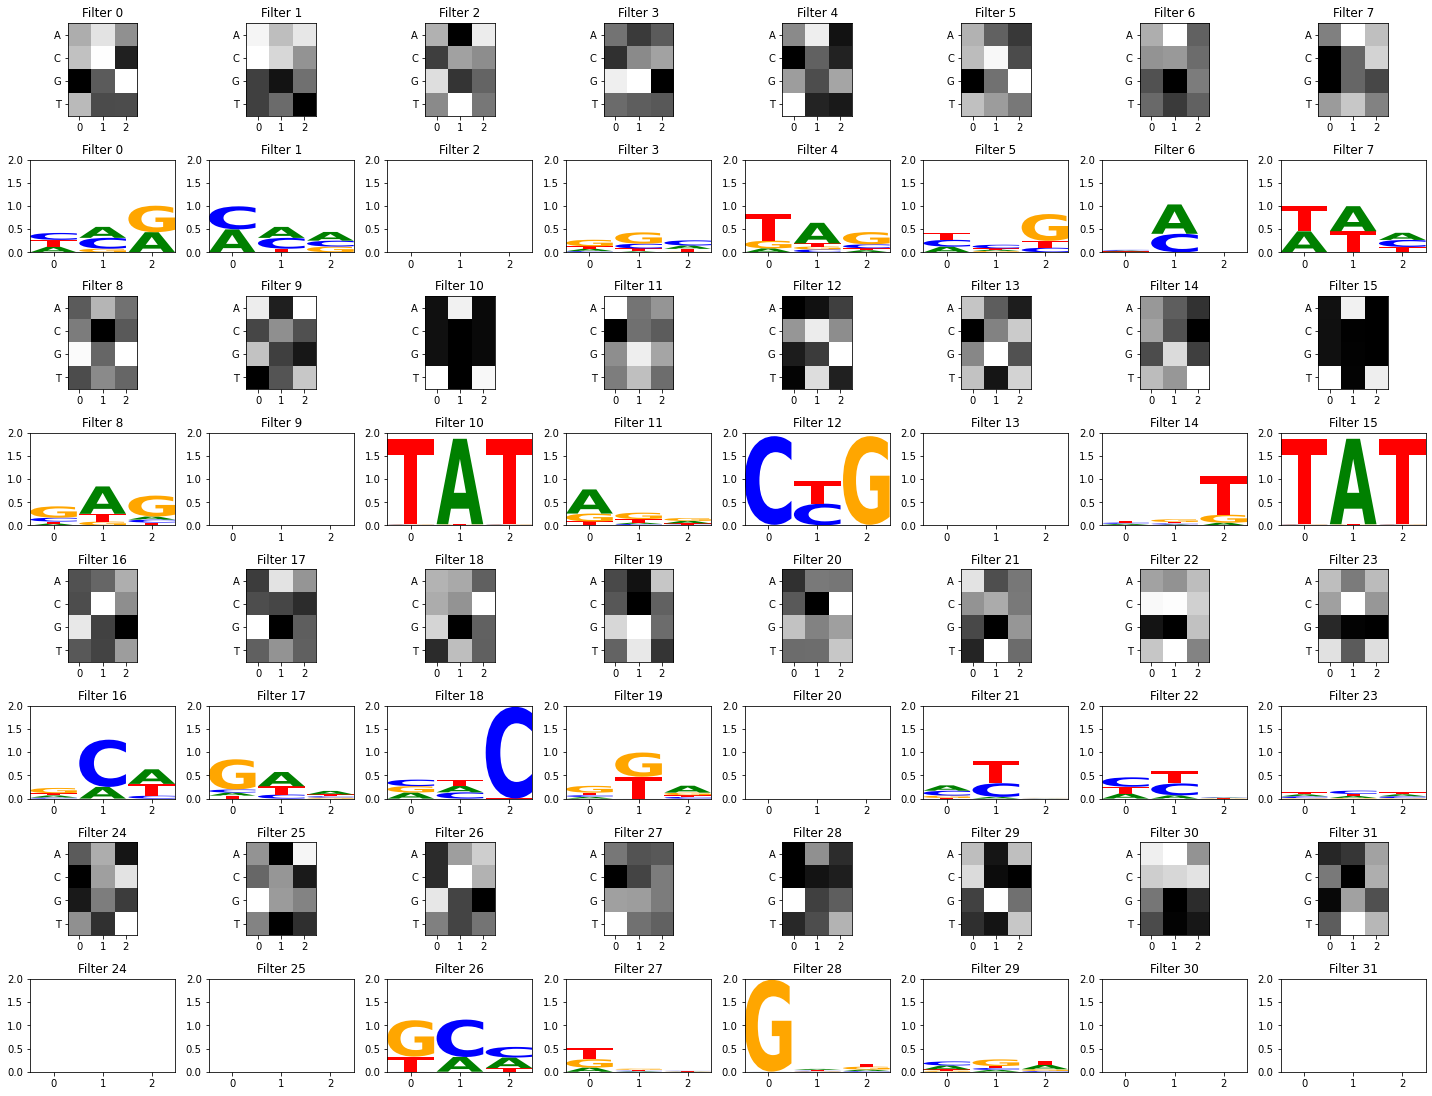

In [43]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [44]:
import torch.autograd as autograd

In [120]:
mer8motif_train_dl,\
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)

In [137]:
class DNA_LSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 layer1_dim=12,
                 #layer2_dim=12
                ):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.hidden_init_values = None
        self.hidden = self.init_hidden()
        
        self.rnn = nn.LSTM(4, hidden_dim)
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
            #nn.Flatten(),
            nn.Linear(hidden_dim, layer1_dim),
            nn.ReLU(inplace=True),
            nn.Linear(layer1_dim, 1),
        )
            
#         self.rnn = nn.Sequential(
#             nn.LSTM(4, hidden_dim),
#             nn.ReLU(inplace=True),
#             nn.Flatten(),
#             nn.Linear(hidden_dim, layer1_dim),
#             nn.ReLU(inplace=True),
#             nn.Linear(layer1_dim, 1),
#         ) 
    
    def init_hidden(self):
        if self.hidden_init_values == None:
            self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
                                       autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
        return self.hidden_init_values
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb):
        # WRONG? reshape view to batch_ssize x 4channel x seq_len
        # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(1,0,2) 
        #print(xb[0])
        #print("xb shape", xb.shape)
        lstm_out, self.hidden = self.rnn(xb)
        #print("lstm_out[0]",lstm_out[0])
        #print(lstm_out.shape)
        #print("self.hidden",self.hidden)
        #print(self.hidden[1].shape)
#         print(self.hidden.shape)
        out = self.fc(lstm_out)
        #print("out",out)
        #print(out.shape)
        return out

In [138]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)

# mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn, lr=0.01)

# # to plot loss
# mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
# u.quick_loss_plot(mer8motif_cnn_data_label)

In [139]:
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10)
  (fc): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=10, out_features=12, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [140]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_lstm, lr=0.01)


0 12.361397430505336
1 12.17838350614106
2 9.511600428450423
3 10.486048194841528
4 9.482120913350805
5 14.095600757178353
6 9.426148090505876
7 10.088726930768162
8 9.427025784706247
9 9.43148098002493
10 9.588540982456152
11 9.606008482836062
12 9.488158758453453
13 9.422492528265483
14 9.49592305498404
15 9.419172401894947
16 9.533394742164809
17 9.384553869641115
18 9.40680327908746
19 9.365689356879269


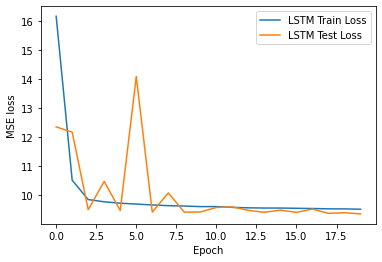

In [141]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

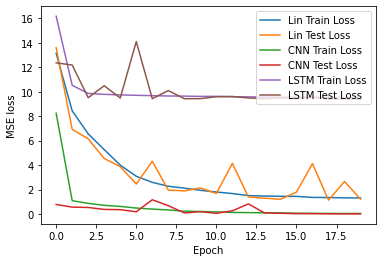

In [142]:
u.quick_loss_plot(comb_data_label+mer8motif_lstm_data_label)